In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from math import sqrt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import (LSTM, Dense, Dropout, BatchNormalization, 
                                     Bidirectional)

2025-02-13 06:01:04.756565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-13 06:01:05.601230: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-13 06:01:05.881428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 06:01:07.642526: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-13 06:01:20.042925: W tensorflow/compiler/tf2

In [2]:
import kagglehub
path = kagglehub.dataset_download("rupakroy/lstm-datasets-multivariate-univariate")

100%|██████████| 444k/444k [00:00<00:00, 22.2MB/s]

Extracting files...


In [3]:
df_train = pd.read_csv(path+'/LSTM-Multivariate_pollution.csv')
df_test = pd.read_csv(path+'/pollution_test_data1.csv')

In [4]:
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

# Define the mapping dictionary
mapping = {'NE': 0, 'SE': 1, 'NW': 2, 'cv': 3}

# Replace the string values with numerical values
df_train_scaled['wnd_dir'] = df_train_scaled['wnd_dir'].map(mapping)
df_test_scaled['wnd_dir'] = df_test_scaled['wnd_dir'].map(mapping)

df_train_scaled['date'] = pd.to_datetime(df_train_scaled['date'])
# Resetting the index
df_train_scaled.set_index('date', inplace=True)
df_train_scaled.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,1,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,1,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,1,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,1,6.25,2,0


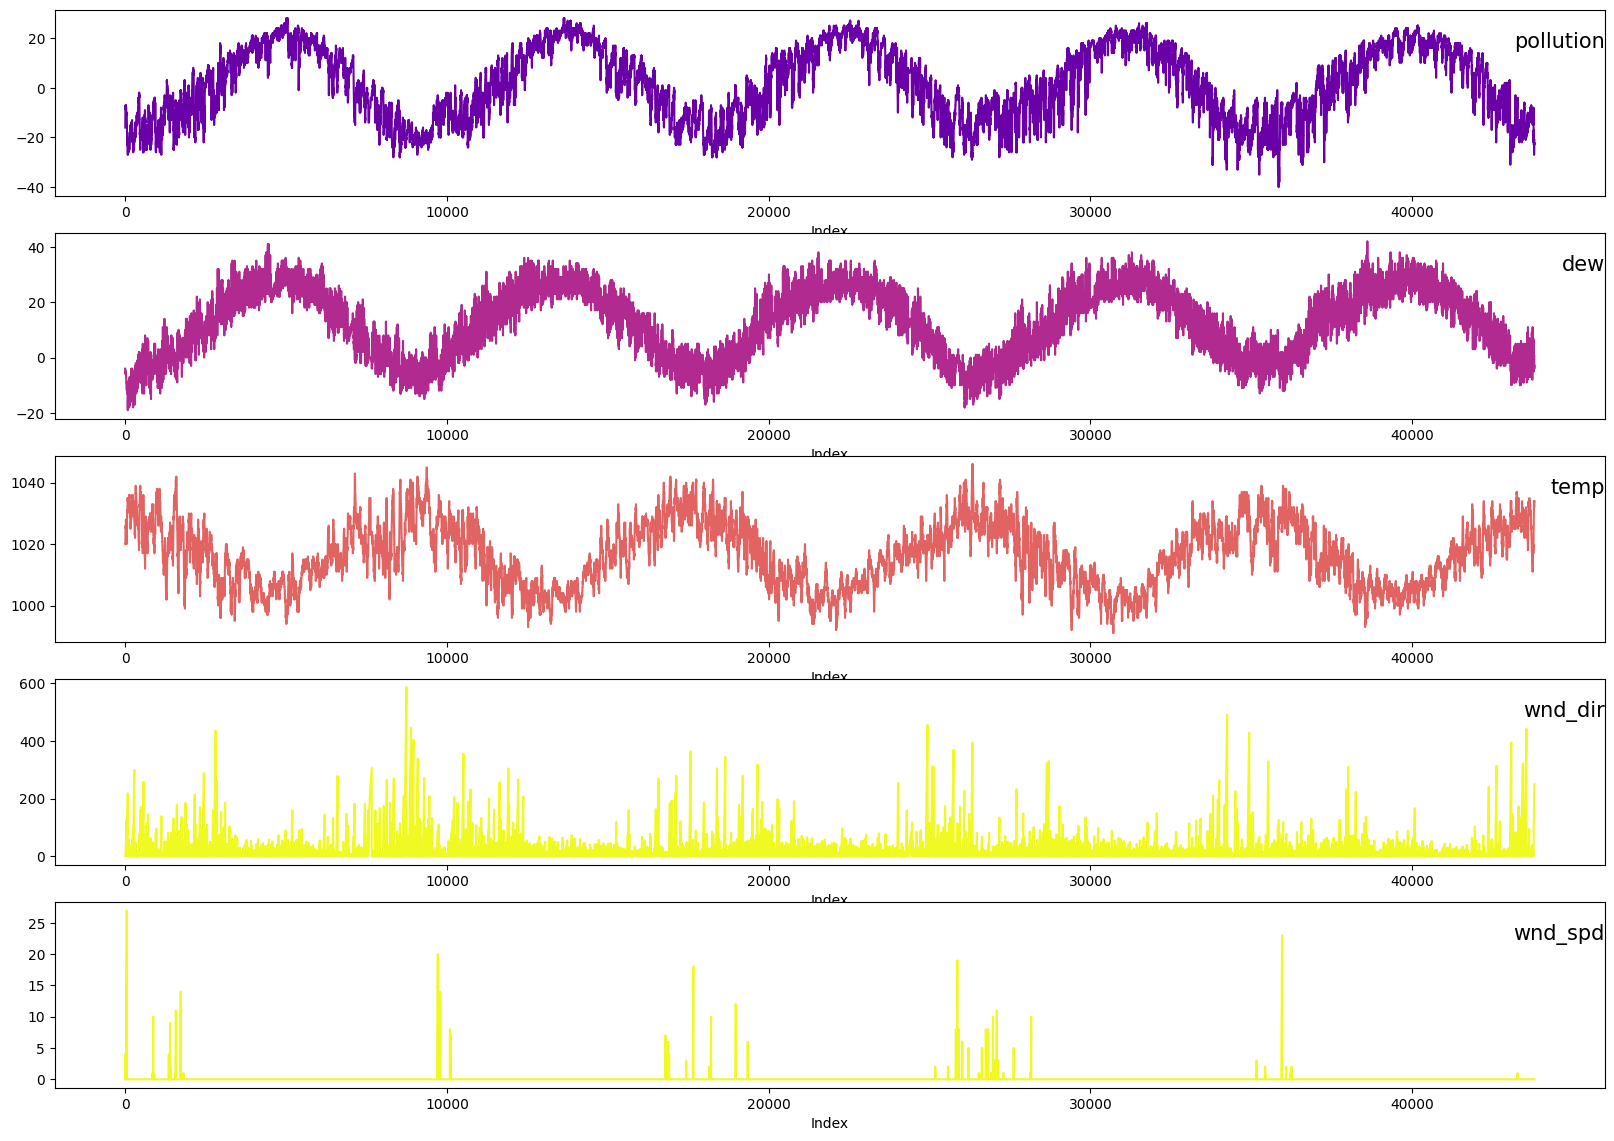

In [5]:
values = df_train_scaled.values

# specify columns to plot
groups = [1, 2, 3, 5, 6]
i = 1

# plot each column
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], color=cm.plasma(group/len(groups)))
    plt.xlabel('Index')
    plt.title(df_train.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

In [6]:
scaler = MinMaxScaler()

# Define the columns to scale
columns = (['pollution', 'dew', 'temp', 'press', "wnd_dir", 'wnd_spd',
       'snow', 'rain'])
    
df_test_scaled = df_test_scaled[columns]

# Scale the selected columns to the range 0-1
df_train_scaled[columns] = scaler.fit_transform(df_train_scaled[columns])
df_test_scaled[columns] = scaler.transform(df_test_scaled[columns])

# Show the scaled data
df_train_scaled.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,0.129779,0.352941,0.245902,0.527273,0.333333,0.002290,0.000000,0.0
2010-01-02 01:00:00,0.148893,0.367647,0.245902,0.527273,0.333333,0.003811,0.000000,0.0
2010-01-02 02:00:00,0.159960,0.426471,0.229508,0.545455,0.333333,0.005332,0.000000,0.0
2010-01-02 03:00:00,0.182093,0.485294,0.229508,0.563636,0.333333,0.008391,0.037037,0.0
2010-01-02 04:00:00,0.138833,0.485294,0.229508,0.563636,0.333333,0.009912,0.074074,0.0


In [7]:
df_train_scaled = np.array(df_train_scaled)
df_test_scaled = np.array(df_test_scaled)

X = []
y = []
n_future = 1
n_past = 11

#  Train Sets
for i in range(n_past, len(df_train_scaled) - n_future+1):
    X.append(df_train_scaled[i - n_past:i, 1:df_train_scaled.shape[1]])
    y.append(df_train_scaled[i + n_future - 1:i + n_future, 0])
X_train, y_train = np.array(X), np.array(y)

print(X_train)
print(y_train)
#  Test Sets

X = []
y = []
for i in range(n_past, len(df_test_scaled) - n_future+1):
    X.append(df_test_scaled[i - n_past:i, 1:df_test_scaled.shape[1]])
    y.append(df_test_scaled[i + n_future - 1:i + n_future, 0])
X_test, y_test = np.array(X), np.array(y)

print('X_train shape : {}   y_train shape : {} \n'
      'X_test shape : {}      y_test shape : {} '.format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

[[[0.35294118 0.24590164 0.52727273 ... 0.00229001 0.         0.        ]
  [0.36764706 0.24590164 0.52727273 ... 0.00381099 0.         0.        ]
  [0.42647059 0.2295082  0.54545455 ... 0.00533197 0.         0.        ]
  ...
  [0.47058824 0.21311475 0.6        ... 0.0206101  0.         0.        ]
  [0.48529412 0.2295082  0.61818182 ... 0.02366914 0.         0.        ]
  [0.48529412 0.2295082  0.63636364 ... 0.0290182  0.03703704 0.        ]]

 [[0.36764706 0.24590164 0.52727273 ... 0.00381099 0.         0.        ]
  [0.42647059 0.2295082  0.54545455 ... 0.00533197 0.         0.        ]
  [0.48529412 0.2295082  0.56363636 ... 0.00839101 0.03703704 0.        ]
  ...
  [0.48529412 0.2295082  0.61818182 ... 0.02366914 0.         0.        ]
  [0.48529412 0.2295082  0.63636364 ... 0.0290182  0.03703704 0.        ]
  [0.47058824 0.2295082  0.63636364 ... 0.03436726 0.         0.        ]]

 [[0.42647059 0.2295082  0.54545455 ... 0.00533197 0.         0.        ]
  [0.48529412 0.229508

In [8]:
# Define model
model = Sequential()
model.add(Bidirectional(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, dropout=0.3, recurrent_dropout=0.2)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(16, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1]))
model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

/home/sxm7770/miniconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Compile the model
model.compile(loss='mse', optimizer=Adam(learning_rate=0.0005), metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Define callbacks for avoiding overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_complex_model.keras', monitor='val_loss', save_best_only=True)

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 11, 256)        │       139,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 11, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 11, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 11, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 11, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361,217 (1.38 MB)

 Trainable params: 360,321 (1.37 MB)

 Non-trainable params: 896 (3.50 KB)

In [11]:
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, callbacks=[early_stopping, checkpoint], shuffle=False)

Epoch 1/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - loss: 0.0191 - root_mean_squared_error: 0.1353 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0906
Epoch 2/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - loss: 0.0086 - root_mean_squared_error: 0.0924 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0895
Epoch 3/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - loss: 0.0084 - root_mean_squared_error: 0.0914 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0896
Epoch 4/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - loss: 0.0084 - root_mean_squared_error: 0.0913 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0897
Epoch 5/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - loss: 0.0084 - root_mean_squared_error: 0.0913 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898
Epoch 6/150
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - loss: 0.0084 - root_mean_squared_error: 0.0913 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0898
Epoch 7/150
1232/1232 

In [15]:
best_model = load_model('best_complex_model.keras')

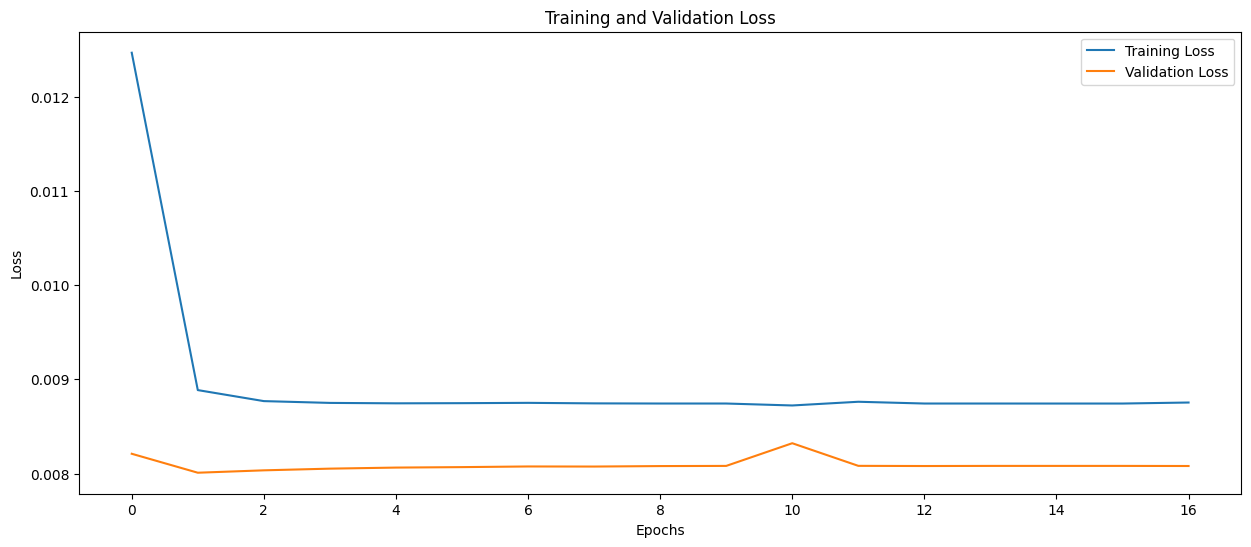

In [16]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
test_predictions = best_model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Train Predictions': test_predictions,
                                  'Actual':y_test.flatten()})
test_results.head()

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step


,Train Predictions,Actual
0,0.087307,0.171026
1,0.087409,0.160966
2,0.087530,0.146881
3,0.087635,0.125755
4,0.087566,0.130785


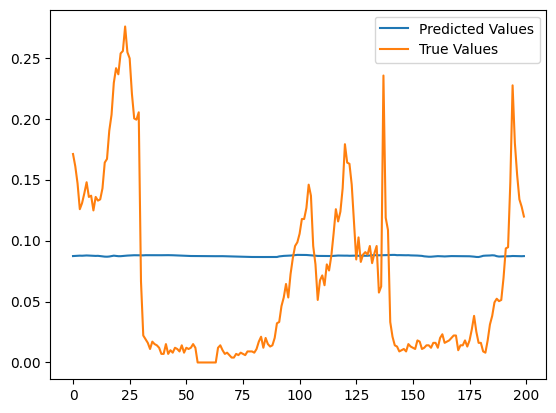

In [18]:
plt.plot(test_results['Train Predictions'][:200], label='Predicted Values')
plt.plot(test_results['Actual'][:200], label='True Values')
plt.legend()
plt.show()

In [19]:
rmse = sqrt(mse(y_test, test_predictions))
print('Test RMSE: %.5f' % rmse)

Test RMSE: 0.09948
